# Preprocessing af SDU dataset

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays

                     Total number of EVs  Number of charging EVs  \
2024-01-01 00:00:00                 0.25                     0.0   
2024-01-01 00:15:00                 0.25                     0.0   
2024-01-01 00:30:00                 0.25                     0.0   
2024-01-01 00:45:00                 0.25                     0.0   
2024-01-01 01:00:00                 0.25                     0.0   
2024-01-01 01:15:00                 0.25                     0.0   
2024-01-01 01:30:00                 0.25                     0.0   
2024-01-01 01:45:00                 0.25                     0.0   
2024-01-01 02:00:00                 0.25                     0.0   
2024-01-01 02:15:00                 0.25                     0.0   

                     Number of driving EVs  Total grid load  \
2024-01-01 00:00:00                    0.0          15.7350   
2024-01-01 00:15:00                    0.0          15.7350   
2024-01-01 00:30:00                    0.0          15.7350   

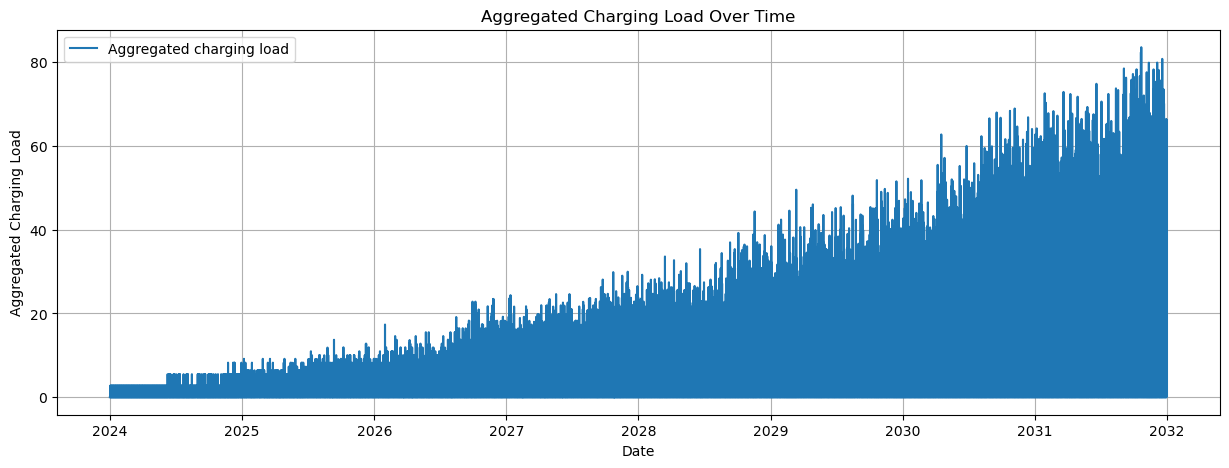

In [63]:
# Input from csv "Jan 1, 2020, 12:00:07 AM"
def parse_date(date):
    return pd.to_datetime(date, format='%b %d, %Y, %I:%M:%S %p')

def convert_to_quarterly(df): 
  df['Timestamp'] = df['Timestamp'].apply(parse_date)
  df = df.set_index('Timestamp')

  # Drop NaN
  df = df.dropna()

  # Drop rows
  df = df.drop(columns=['Passed hours', 'Year', 'Month', 'Day', 'Hour', 'Minute'])

  quarterly = []

  for timestamp, row in df.iterrows():
      for quarter in [0, 15, 30, 45]:
          new_timestamp = timestamp.replace(minute=quarter, second=0, microsecond=0)
          new_row = row / 4 
          quarterly.append((new_timestamp, new_row))
  
  df_quarterly = pd.DataFrame(
      [row for _, row in quarterly], 
      index=[ts for ts, _ in quarterly]
  )

  df_quarterly.sort_index(inplace=True)
  return df_quarterly


def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Aggregated_charging_load_15min'] = df['Aggregated charging load'].shift(1)
  df['Aggregated_charging_load_90min'] = df['Aggregated charging load'].shift(6)
  df['Aggregated_charging_load_3h'] = df['Aggregated charging load'].shift(12)
  df['Aggregated_charging_load_6h'] = df['Aggregated charging load'].shift(24)
  df['Aggregated_charging_load_1w'] = df['Aggregated charging load'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Aggregated charging load'].rolling(window=24).mean()

  return df


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()



# Define the start and end dates
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2032-01-01')

df_dumb = pd.read_csv('./DumbCharging_2020_to_2032/Measurements.csv')

df_quarterly = convert_to_quarterly(df_dumb)
df_quarterly = add_features(df_quarterly)
df_quarterly = filter_data(start_date, end_date, df_quarterly)

# Save the DataFrame to a CSV file
#df_quarterly.to_csv('./Measurements_quarterly.csv')

print(df_quarterly.head(10))

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(df_quarterly.index, df_quarterly['Aggregated charging load'], label='Aggregated charging load')
plt.title('Aggregated Charging Load Over Time')
plt.xlabel('Date')
plt.ylabel('Aggregated Charging Load')
plt.legend()
plt.grid()
plt.show()


## Plotting Original dataset

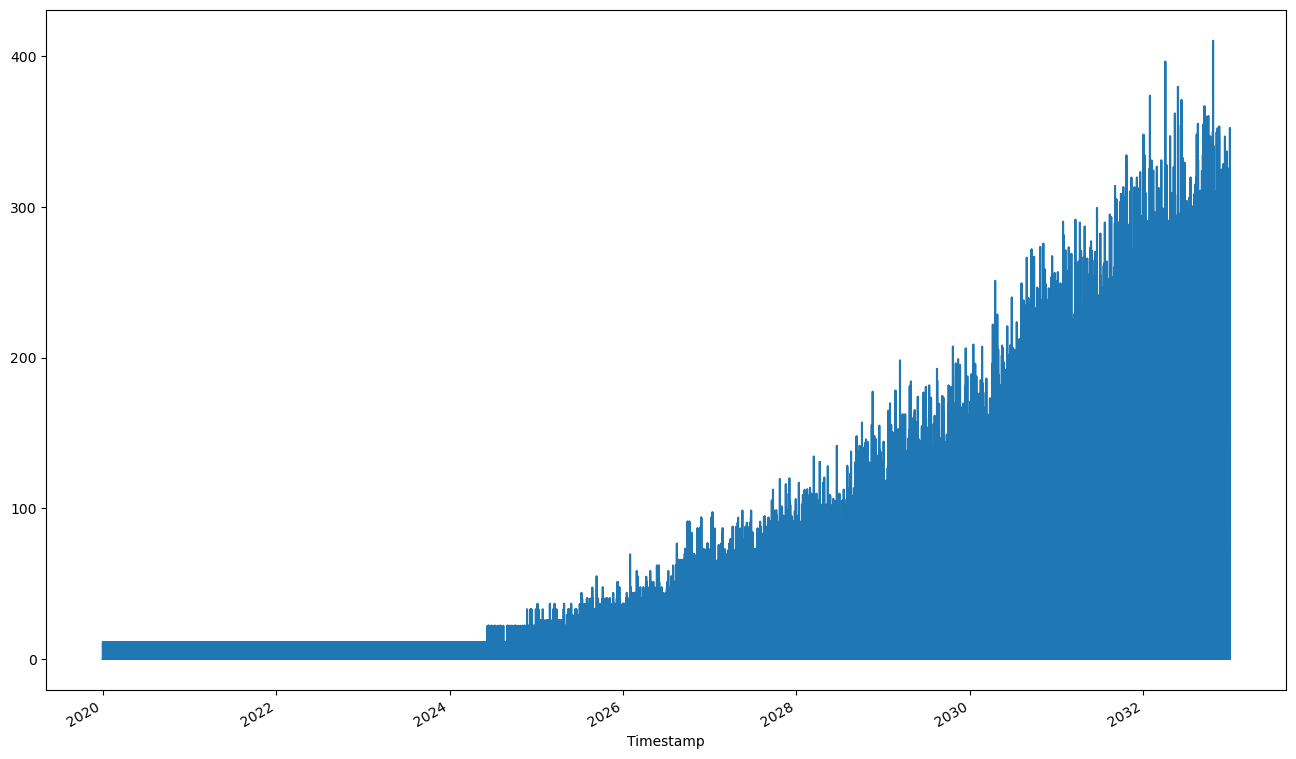

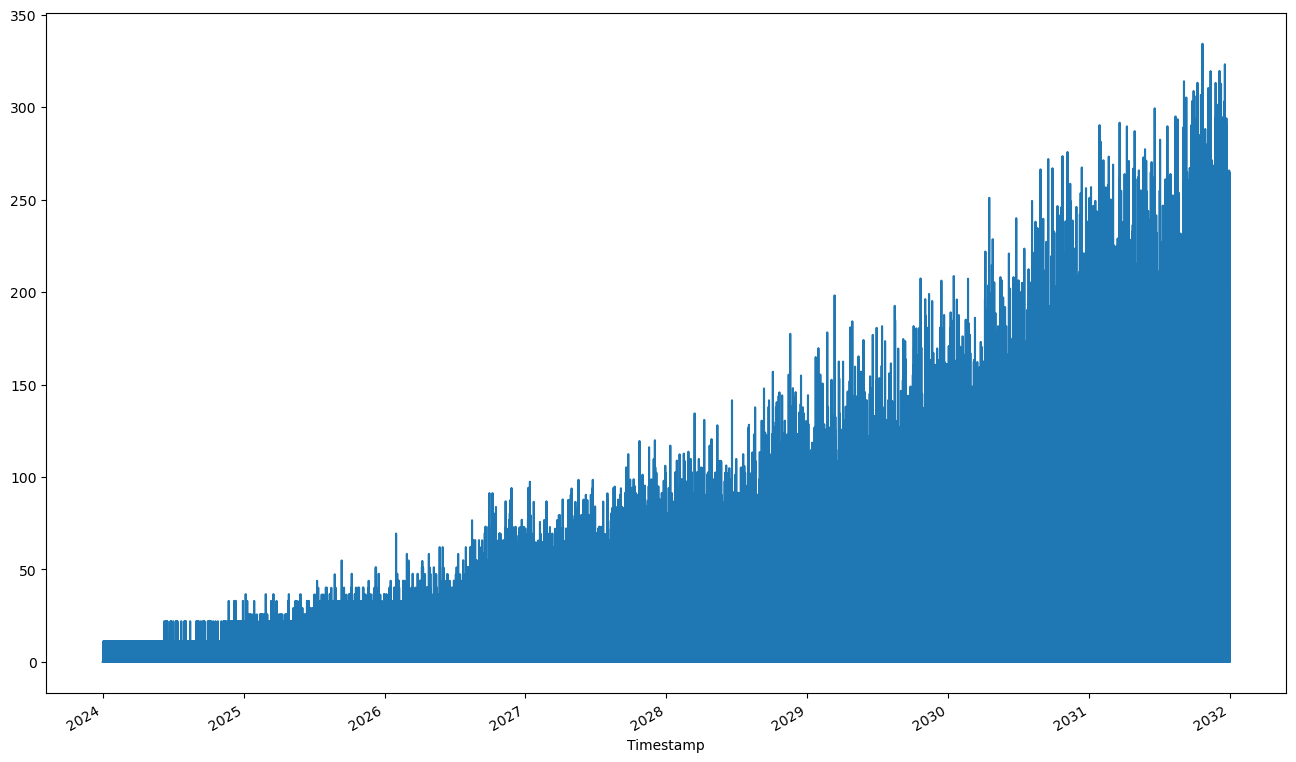

In [59]:
# Input from csv "Jan 1, 2020, 12:00:07 AM"
def parse_date(date):
    return pd.to_datetime(date, format='%b %d, %Y, %I:%M:%S %p')


df_dumb = pd.read_csv('./DumbCharging_2020_to_2032/Measurements.csv')
df_dumb['Timestamp'] = df_dumb['Timestamp'].apply(parse_date)
df_dumb = df_dumb.set_index('Timestamp')

# plot the average charging load over the years 
df_dumb['Aggregated charging load'].plot(figsize=(16, 10))
plt.show()

#plot 2024 - 2032
df_dumb['Aggregated charging load'].loc['2024-01-01':'2032-01-01'].plot(figsize=(16, 10))
plt.show()